In [1]:
import pandas as pd
import numpy as np
from pandas import read_csv
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')
# Read the dataset
data = pd.read_csv('processed_data_with_target_regression3.csv')

In [34]:

# Display the first few rows
print(data.head())

   process.b1.capacity  process.b2.capacity  process.b3.capacity  \
0                  0.0                  0.0                  1.0   
1                  0.0                  0.0                  1.0   
2                  0.0                  0.0                  1.0   
3                  0.0                  0.0                  1.0   
4                  0.0                  0.0                  1.0   

   process.b4.capacity  property.price  property.product  property.winner  \
0                  1.0        0.000000               0.0              0.0   
1                  1.0        0.000000               0.2              0.0   
2                  1.0        0.000000               0.6              0.0   
3                  1.0        0.000000               1.0              0.0   
4                  1.0        0.032258               0.0              0.0   

   verification.time  
0         163.316667  
1         200.860000  
2         154.888889  
3         108.640000  
4          85

In [24]:

# Separate features (X) and target (y)
X = data.drop(['verification.time'], axis=1).values  # All columns except the target = Feateurs
y = data['verification.time'].values  #  Target

In [36]:
print(X)

[[0.   0.   1.   ... 0.   0.   0.  ]
 [0.   0.   1.   ... 0.   0.2  0.  ]
 [0.   0.   1.   ... 0.   0.6  0.  ]
 ...
 [1.   1.   1.   ... 1.   0.8  0.5 ]
 [1.   1.   1.   ... 1.   0.8  0.75]
 [1.   1.   1.   ... 1.   0.8  1.  ]]


In [5]:
# Add intercept term to X (for the bias term in the model)
X = np.c_[np.ones(X.shape[0]), X]  # Add a column of ones

In [10]:
print(X)

[[1.   0.   0.   ... 0.   0.   0.  ]
 [1.   0.   0.   ... 0.   0.2  0.  ]
 [1.   0.   0.   ... 0.   0.6  0.  ]
 ...
 [1.   1.   1.   ... 1.   0.8  0.5 ]
 [1.   1.   1.   ... 1.   0.8  0.75]
 [1.   1.   1.   ... 1.   0.8  1.  ]]


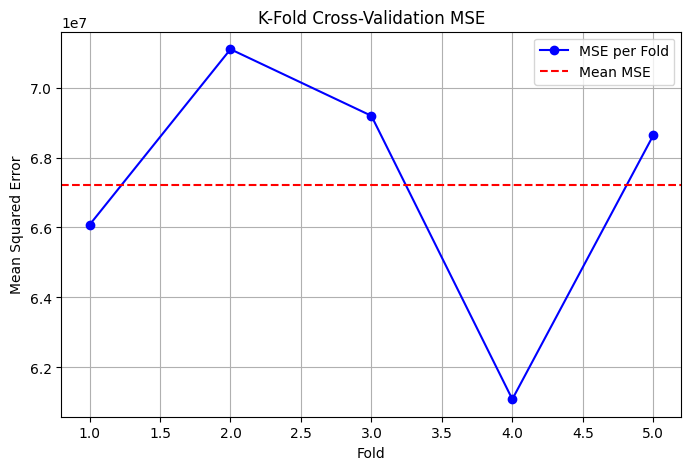

Average MSE across folds: 67217681.9325


In [56]:
from sklearn.model_selection import KFold

# Define the normal equation function
def normal_equation(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y  # Compute theta using the normal equation


# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]  # Use NumPy slicing instead of .iloc

    # Compute theta using the normal equation
    theta = normal_equation(X_train, y_train)

    # Make predictions
    y_pred = X_test @ theta

    # Calculate mean squared error
    mse = np.mean((y_test - y_pred) ** 2)
    mse_scores.append(mse)

# Plot the MSE scores
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(mse_scores) + 1), mse_scores, marker='o', linestyle='-', color='b', label='MSE per Fold')
plt.axhline(y=np.mean(mse_scores), color='r', linestyle='--', label='Mean MSE')
plt.title("K-Fold Cross-Validation MSE")
plt.xlabel("Fold")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.show()

# Print average MSE
print(f"Average MSE across folds: {np.mean(mse_scores):.4f}")


Fold 1 MSE: 67701404.64555527, Adjusted R^2: 0.33947904280278074
Fold 2 MSE: 73647190.65418996, Adjusted R^2: 0.326213887465825
Fold 3 MSE: 70272504.0484497, Adjusted R^2: 0.39207398826440754
Fold 4 MSE: 62672360.249300346, Adjusted R^2: 0.30395631664999523
Fold 5 MSE: 71551427.46354078, Adjusted R^2: 0.3486779654732669


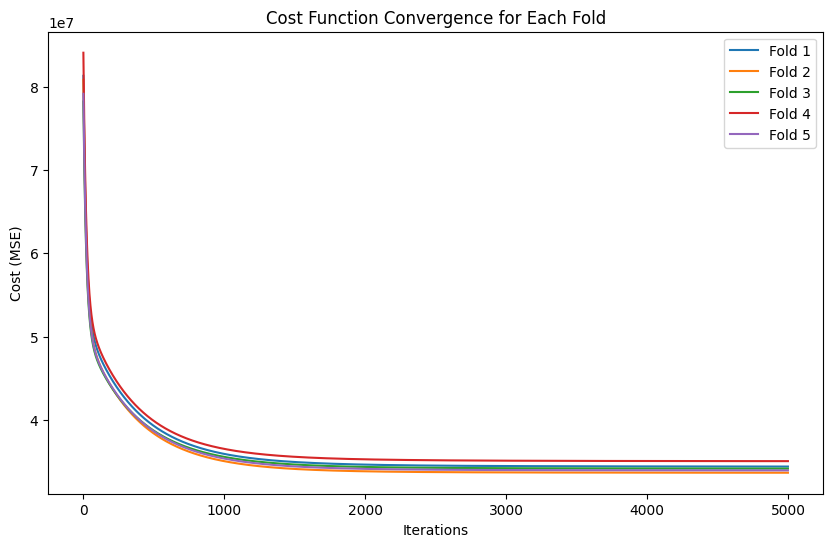


MSE for each fold: [67701404.64555527, 73647190.65418996, 70272504.0484497, 62672360.249300346, 71551427.46354078]
Average MSE across folds: 69168977.41220722

Adjusted R^2 for each fold: [0.33947904280278074, 0.326213887465825, 0.39207398826440754, 0.30395631664999523, 0.3486779654732669]
Average Adjusted R^2 across folds: 0.34208024013125504


In [27]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Updated gradient descent function to track cost history
def gradient_descent(X, y, alpha, num_iters):
    m = len(y)
    thetas = np.zeros(X.shape[1])  # Initialize thetas
    cost_history = []  # To track cost function values

    for i in range(num_iters):
        predictions = X @ thetas  # Compute predictions
        errors = predictions - y
        gradient = (1 / m) * (X.T @ errors)  # Compute gradients
        thetas -= alpha * gradient  # Update thetas

        # Compute the cost function (Mean Squared Error)
        cost = (1 / (2 * m)) * np.sum(errors**2)
        cost_history.append(cost)

    return thetas, cost_history

# Calculate Adjusted R-squared
def adjusted_r2(y_true, y_pred, p):
    n = len(y_true)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
    return adj_r2

# Updated k_fold_cross_validation to include cost function tracking and Adjusted R^2
def k_fold_cross_validation_with_cost_and_r2_plot(X, y, k, alpha, num_iters):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)  # Shuffle ensures randomness
    metrics = []  # To store Mean Squared Error for each fold
    adj_r2_scores = []  # To store Adjusted R^2 for each fold
    cost_histories = []  # To track cost function history for each fold

    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the model using Gradient Descent
        thetas, cost_history = gradient_descent(X_train, y_train, alpha, num_iters)
        cost_histories.append(cost_history)

        # Make predictions
        y_pred = X_test @ thetas

        # Compute Mean Squared Error
        mse = mean_squared_error(y_test, y_pred)
        metrics.append(mse)

        # Calculate Adjusted R-squared
        p = X_train.shape[1]  # Number of features
        adj_r2 = adjusted_r2(y_test, y_pred, p)
        adj_r2_scores.append(adj_r2)

        print(f"Fold {fold + 1} MSE: {mse}, Adjusted R^2: {adj_r2}")

    return metrics, adj_r2_scores, cost_histories

# Run k-Fold Cross-Validation with Cost Function Plotting and Adjusted R^2 Calculation
k = 5  # Number of folds
alpha = 0.01 # Learning rate
num_iters = 5000  # Number of iterations

# Perform k-fold cross-validation
mse_scores, adj_r2_scores, cost_histories = k_fold_cross_validation_with_cost_and_r2_plot(X, y, k, alpha, num_iters)

# Plot cost function for each fold
plt.figure(figsize=(10, 6))
for fold, cost_history in enumerate(cost_histories):
    plt.plot(range(len(cost_history)), cost_history, label=f"Fold {fold + 1}")
plt.xlabel("Iterations")
plt.ylabel("Cost (MSE)")
plt.title("Cost Function Convergence for Each Fold")
plt.legend()
plt.show()

# Print MSE and Adjusted R^2 results
print("\nMSE for each fold:", mse_scores)
print("Average MSE across folds:", np.mean(mse_scores))
print("\nAdjusted R^2 for each fold:", adj_r2_scores)
print("Average Adjusted R^2 across folds:", np.mean(adj_r2_scores))


Fold 1: MSE = 33888812.4019, Adjusted R^2 = 0.4566
Fold 2: MSE = 37427933.9541, Adjusted R^2 = 0.4372
Fold 3: MSE = 33922170.1487, Adjusted R^2 = 0.5177
Fold 4: MSE = 33346791.1531, Adjusted R^2 = 0.3904
Fold 5: MSE = 38168102.3785, Adjusted R^2 = 0.4281


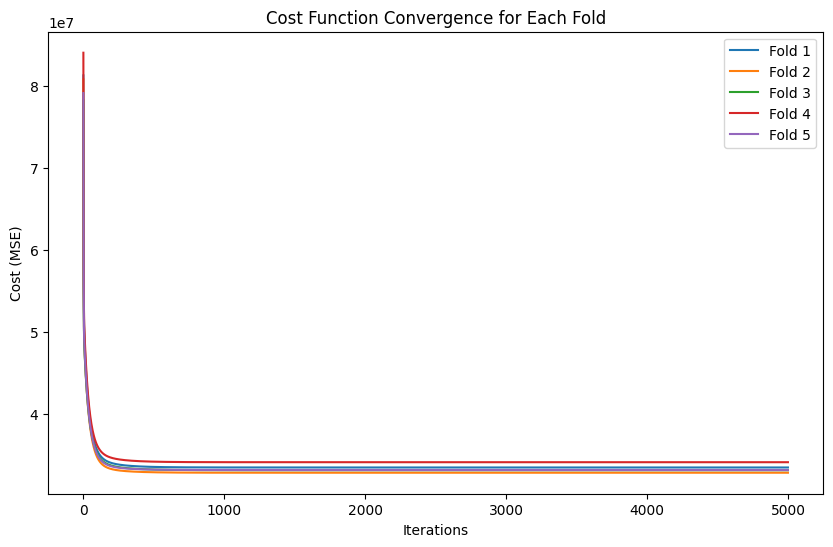


MSE for each fold: [33888812.40186309, 37427933.95406874, 33922170.148711376, 33346791.153054867, 38168102.378491946]
Average MSE across folds: 35350762.007238

Adjusted R^2 for each fold: [0.4566247935507747, 0.43724900534636746, 0.5177153145416034, 0.39036735714933035, 0.42808464795038526]
Average Adjusted R^2 across folds: 0.44600822370769216


In [23]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Adjusted R^2 calculation
def adjusted_r2(y_true, y_pred, p):
    n = len(y_true)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
    return adj_r2

# K-Fold Cross-Validation with Ridge Regression and Feature Scaling
def k_fold_ridge_with_scaling(X, y, k, alpha, degree):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    mse_scores = []
    adj_r2_scores = []

    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Build a pipeline with polynomial features, scaling, and Ridge regression
        pipeline = Pipeline([
            ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
            ("scaler", StandardScaler()),
            ("ridge", Ridge(alpha=alpha))
        ])

        # Train the pipeline
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        # Calculate MSE and Adjusted R²
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)

        p = pipeline.named_steps['poly'].n_output_features_  # Get number of features after polynomial expansion
        adj_r2 = adjusted_r2(y_test, y_pred, p)
        adj_r2_scores.append(adj_r2)

        print(f"Fold {fold + 1}: MSE = {mse:.4f}, Adjusted R^2 = {adj_r2:.4f}")

    return mse_scores, adj_r2_scores

# Run the updated Ridge regression with scaling
k = 5  # Number of folds
alpha = 0.1  # Regularization parameter
degree = 3  # Polynomial degree

mse_scores, adj_r2_scores = k_fold_ridge_with_scaling(X, y, k, alpha, degree)


# Plot cost function for each fold
plt.figure(figsize=(10, 6))
for fold, cost_history in enumerate(cost_histories):
    plt.plot(range(len(cost_history)), cost_history, label=f"Fold {fold + 1}")
plt.xlabel("Iterations")
plt.ylabel("Cost (MSE)")
plt.title("Cost Function Convergence for Each Fold")
plt.legend()
plt.show()


print("\nMSE for each fold:", mse_scores)
print("Average MSE across folds:", np.mean(mse_scores))
print("\nAdjusted R^2 for each fold:", adj_r2_scores)
print("Average Adjusted R^2 across folds:", np.mean(adj_r2_scores))
